In [24]:
 # Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# Keras deep learning imports
import keras
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Dropout, Input, add 
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras import optimizers

# Data splitting
from sklearn.model_selection import train_test_split

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [25]:
x = np.load('./dataset/sign-language/X.npy')
y = np.load('./dataset/sign-language/Y.npy')

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')

X shape: (2062, 64, 64)
Y shape: (2062, 10)


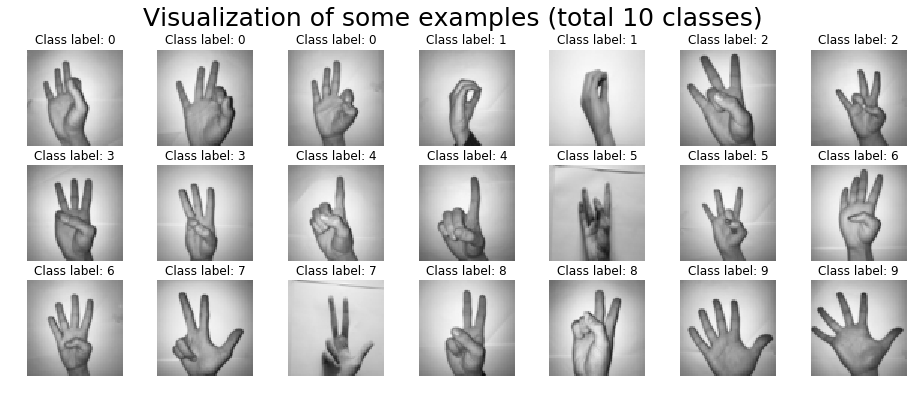

In [26]:
plt.figure(figsize=(16, 6))
figIdx = 1
for i in range(len(x)):
    if i%100==0 and figIdx <= 3*7:
        plt.subplot(3,7,figIdx)
        plt.title(f'Class label: {y[i].argmax()}')
        plt.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        figIdx+=1
plt.suptitle(f'Visualization of some examples (total {y.shape[1]} classes)', fontsize=25)
plt.show()

In [27]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state = 42)
xTrain = xTrain.reshape(-1, 64, 64, 1)
xTest = xTest.reshape(-1, 64, 64, 1)

In [28]:

class ResNet:
    def resnet_blocks(x, F, stride, red=False,reg=0.0001, bnEps=2e-5, bnMom=0.9):

        shortcut = x
  
        x = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = Conv2D(F, kernel_size = (1, 1), kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)
        
        
        x = Conv2D(F, kernel_size=(3, 3), strides=stride, padding="same", kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=-1, epsilon=bnEps,momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = Conv2D(F, (1, 1), kernel_regularizer=l2(reg))(x)
        
        if red:
            shortcut = Conv2D(F, kernel_size=(1, 1), strides=stride, kernel_regularizer=l2(reg))(shortcut)

        x = add([x, shortcut])

        return x
    
    
    def create_resnet(numClasses, inputShape, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9):
        
        inputs = Input(shape=inputShape)
        
        x = BatchNormalization(axis=-1, epsilon=bnEps,momentum=bnMom)(inputs)

        x = Conv2D(filters[0], (5, 5),padding="same", kernel_regularizer=l2(reg))(x)
        x = BatchNormalization(axis=-1, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = Dropout(0.2)(x)
        
        for i in range(0, len(stages)):
            stride = (1, 1) if i == 0 else (2, 2)
            
            # ResNet Identity Block
            x = ResNet.resnet_blocks(x, filters[i + 1], stride, red=True, bnEps=bnEps, bnMom=bnMom)
            
            # ResNet Convolutional block
            for j in range(0, stages[i] - 1):
                x = ResNet.resnet_blocks(x, filters[i + 1], (1, 1), bnEps=bnEps, bnMom=bnMom)
                
        x = BatchNormalization(axis=-1, epsilon=bnEps,momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = MaxPooling2D((8, 8))(x)
        x = Dropout(0.2)(x)
        
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        out = Dense(numClasses, activation = "softmax")(x)
  
        model = Model(inputs = inputs, outputs = out)

        return model

In [31]:
inputShape = (64, 64, 1)

model = ResNet.create_resnet(10, inputShape, 
                             stages=(2, 3, 4), 
                             filters=(16, 32, 64, 64), 
                             reg=0.001, bnEps=2e-4, bnMom=0.98)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=0.0008, decay = 1e-6),
             metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 64, 64, 1)    4           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 64, 64, 16)   416         batch_normalization_181[0][0]    
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 64, 64, 16)   64          conv2d_187[0][0]                 
__________________________________________________________________________________________________
activation

In [32]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                min_delta = 0.0,
                                                patience = 10, 
                                                verbose = 1, 
                                                mode = 'auto',
                                                baseline = None, 
                                                restore_best_weights = True)

epochs = 100
history = model.fit(xTrain, yTrain, 
                    epochs=epochs, validation_data=(xTest, yTest), 
                    callbacks=[early_stopping])


Train on 1649 samples, validate on 413 samples
Epoch 1/100
1649/1649 [==============================] - 47s 29ms/step - loss: 2.9816 - acc: 0.0982 - val_loss: 2.4609 - val_acc: 0.1065
Epoch 2/100
1649/1649 [==============================] - 25s 15ms/step - loss: 2.5605 - acc: 0.1225 - val_loss: 2.4481 - val_acc: 0.1162
Epoch 3/100
1649/1649 [==============================] - 24s 15ms/step - loss: 2.4157 - acc: 0.1601 - val_loss: 2.2622 - val_acc: 0.2397
Epoch 4/100
1649/1649 [==============================] - 28s 17ms/step - loss: 2.3292 - acc: 0.1777 - val_loss: 2.2017 - val_acc: 0.2470
Epoch 5/100
1649/1649 [==============================] - 28s 17ms/step - loss: 2.2760 - acc: 0.2038 - val_loss: 2.1172 - val_acc: 0.2954
Epoch 6/100
1649/1649 [==============================] - 25s 15ms/step - loss: 2.1611 - acc: 0.2456 - val_loss: 2.0011 - val_acc: 0.2978
Epoch 7/100
1649/1649 [==============================] - 24s 15ms/step - loss: 1.9820 - acc: 0.3196 - val_loss: 1.7567 - val_acc: 0

Epoch 00059: early stopping


In [33]:
model.save_weights('./weights/asl-digits-resnet_1.h5')

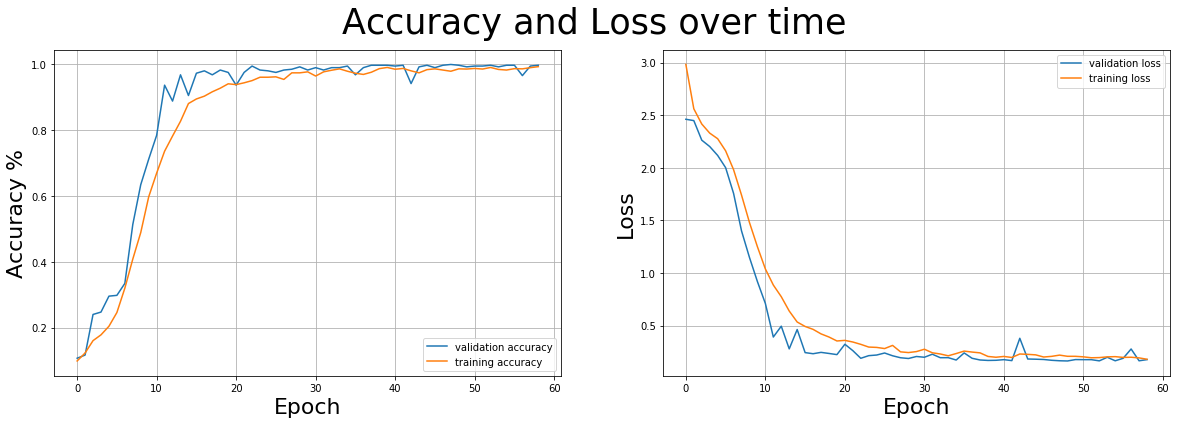

In [58]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(history.history["val_acc"],label="validation accuracy")
plt.plot(history.history["acc"],label="training accuracy")
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Accuracy %', fontsize = 22)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation loss")
plt.plot(history.history["loss"],label="training loss")
plt.xlabel('Epoch', fontsize = 22)
plt.ylabel('Loss', fontsize = 22)
plt.legend()
plt.grid(True)

plt.suptitle("Accuracy and Loss over time",fontsize=35)

plt.show()

In [35]:
pred = model.predict(xTest)
predLabels = np.argmax(pred, axis = 1)
yLabels = np.argmax(yTest, axis=1)

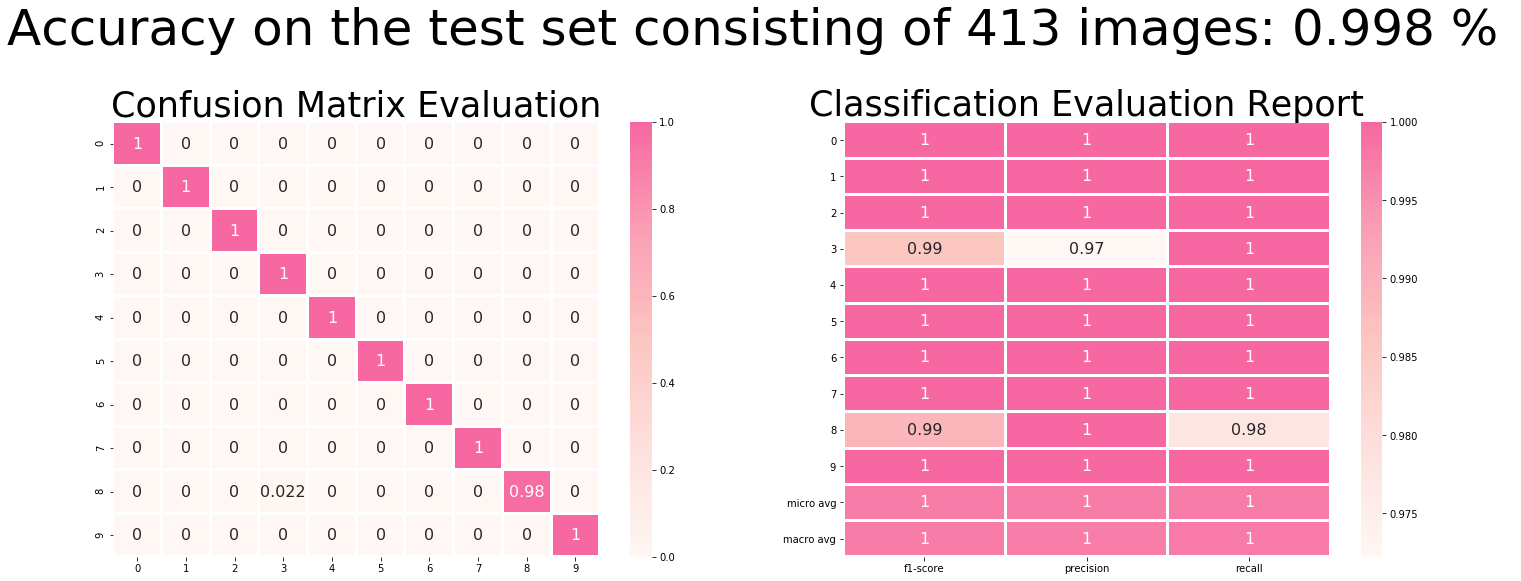

<Figure size 432x288 with 0 Axes>

In [52]:
cm = confusion_matrix(yLabels, predLabels)
cmNorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmNorm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])

target_names = list("0123456789")
labels = np.arange(10)
clf_report = classification_report(yLabels,
                                   predLabels,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)
accList = []
for i in range(len(cmNorm)):
    accList.append(cmNorm[i][i])

plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
sns.heatmap(df_cm, annot=True, cmap="RdPu", 
                center=True, linewidths=2,annot_kws={'size':16})
plt.title('Confusion Matrix Evaluation', fontsize=35)


plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:-1].T, 
            annot=True,cmap="RdPu", center=True, linewidths=2,annot_kws={'size':16})
plt.title('Classification Evaluation Report', fontsize = 35)
plt.suptitle('Accuracy on the test set consisting of {} images: {:.3f} % \n'.format(len(yTest), np.mean(accList)), fontsize = 50, y=1.08)

plt.show()
plt.savefig('./Evaluation/resnet.png')